In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import re 

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
df_interestrates = pd.read_csv('/Users/ir3n3br4t515/Desktop/index.csv')
df_zillowsale = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_State.csv')
df_zillowrent = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianRentalPrice_AllHomes.csv')
df_daysonzillow = pd.read_csv('/Users/ir3n3br4t515/Desktop/DaysOnZillow_State.csv')
df_sale_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_City.csv')
df_pricepsqft = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianListingPricePerSqft_AllHomes.csv')
df_saleneighborhood = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_Neighborhood.csv')
df_rent_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/City_Zri_AllHomesPlusMultifamily.csv', encoding='iso-8859-1') 



In [3]:
def transform_date(year, month):
    year = str(year).split(".")[0]
    month = str(month).split(".")[0]
    if len(month)==1:
        month = "0" + month
    return year + "-" + month

In [4]:
df_interestrates["date"] = df_interestrates.apply(lambda x: transform_date(x.Year, x.Month), axis=1)

In [5]:
#I will only be looking at the year, month, unemployment, inflation and effective federal funds rates for each year so i will make a new df.
df_econ = df_interestrates[['date', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
df_econ.head()

,date,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate
0,1954-07,5.8,NaN,0.80
1,1954-08,6.0,NaN,1.22
2,1954-09,6.1,NaN,1.06
3,1954-10,5.7,NaN,0.85
4,1954-11,5.3,NaN,0.83


In [6]:
df_econ = df_econ.set_index("date")

In [7]:
df_rent = df_zillowrent.iloc[[2, 13]]

df_rent.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3150,3100,3195.0,3200.0,3490,3295,3260,3200,3375.0,3234.0
13,Massachusetts,14,NaN,NaN,1552.5,1675.0,1552.5,1775.0,1550.0,1600.0,...,2500,2550,2600.0,2699.0,2700,2700,2700,2695,2599.0,2500.0


In [8]:
df_rent = df_rent.T
df_rent.columns = ["NY_R", "MA_R"]

In [9]:
df_rent = df_rent.drop("RegionName", axis=0)
df_rent = df_rent.drop("SizeRank", axis=0)

In [10]:
df_rent.head()

,NY_R,MA_R
2010-01,NaN,NaN
2010-02,NaN,NaN
2010-03,NaN,1552.5
2010-04,NaN,1675
2010-05,NaN,1552.5


In [11]:
df_sale = df_zillowsale.iloc[[1, 12]]
df_sale.head(100)

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
1,43,New York,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291200,297800,297400,294700,292600.0,296500.0,306300.0,311100.0,314400.0,NaN
12,26,Massachusetts,13,314500.0,309500.0,297400.0,291300.0,287900.0,288200.0,285400.0,...,368000,368500,378400,388000,390200.0,384100.0,383300.0,385800.0,385600.0,NaN


In [12]:
df_sale = df_sale.T
df_sale.columns = ["NY_S", "MA_S"]

In [13]:
df_sale.head(100)

,NY_S,MA_S
RegionID,43,26
RegionName,New York,Massachusetts
SizeRank,2,13
2008-03,NaN,314500
2008-04,NaN,309500
...,...,...
2015-11,238600,325500
2015-12,239000,327600
2016-01,236900,327100
2016-02,233400,328600


In [14]:
df_daysonzillow.head(100)

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,9,California,State,109.0,115.0,107.0,103.0,89.0,91.0,...,73.0,83.0,82.0,62.0,58.0,56.0,57.0,60.0,62.0,64
1,2.0,54,Texas,State,121.0,124.0,122.0,112.0,98.0,100.0,...,82.0,88.0,88.0,73.0,66.0,63.0,63.0,63.0,66.0,73
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
3,4.0,14,Florida,State,163.0,157.0,155.0,158.0,152.0,131.0,...,88.0,95.0,100.0,95.0,87.0,87.0,86.0,85.0,84.0,85
4,5.0,21,Illinois,State,174.0,177.0,178.0,181.0,161.0,129.0,...,105.0,116.0,126.0,121.0,83.0,75.0,76.0,80.0,83.0,88
5,6.0,47,Pennsylvania,State,137.0,150.0,151.0,152.0,122.0,112.0,...,89.0,98.0,107.0,104.0,83.0,73.0,72.0,73.0,75.0,77
6,7.0,44,Ohio,State,143.0,153.0,153.0,152.0,124.0,110.0,...,78.0,88.0,96.0,81.0,66.0,60.0,59.0,61.0,62.0,63
7,8.0,30,Michigan,State,135.0,140.0,140.0,143.0,125.0,115.0,...,81.0,91.0,95.0,92.0,72.0,62.0,61.0,63.0,66.0,70
8,9.0,16,Georgia,State,158.0,164.0,161.0,160.0,152.0,126.0,...,81.0,89.0,89.0,67.0,68.0,64.0,64.0,67.0,69.0,73
9,10.0,36,North Carolina,State,172.0,170.0,167.0,175.0,141.0,126.0,...,82.0,91.0,92.0,72.0,63.0,61.0,63.0,63.0,67.0,70


In [15]:
df_dayszillow = df_daysonzillow.iloc[[2, 13]]
df_dayszillow.head()

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
13,14.0,26,Massachusetts,State,149.0,157.0,153.0,153.0,118.0,110.0,...,79.0,93.0,105.0,84.0,70.0,67.0,66.0,69.0,72.0,77


In [16]:
df_dayszillow = df_dayszillow.T
df_dayszillow.columns = ["NY_days", "MA_days"]

In [17]:
df_dayszillow = df_dayszillow.drop("RegionName", axis=0)
df_dayszillow = df_dayszillow.drop("RegionID", axis=0)
df_dayszillow = df_dayszillow.drop("SizeRank", axis=0)

In [18]:
df_dayszillow.head()

,NY_days,MA_days
RegionType,State,State
2010-01,189,149
2010-02,193,157
2010-03,192,153
2010-04,185,153


In [19]:
df_pricepsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,California,1,210.117014,213.913415,215.515176,218.470343,219.435737,219.593665,216.994638,215.915617,...,308.848080,314.343087,320.359281,325.009560,323.809524,324.306252,323.155894,321.212121,322.713308,323.105102
1,Texas,2,85.757867,86.131934,86.633663,86.944938,86.935406,86.698795,85.991245,85.588467,...,126.404743,127.062333,128.057091,129.592471,129.731514,130.081301,129.933397,129.761481,129.986245,129.841549
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
3,Florida,4,119.438669,118.257963,116.842517,115.427233,114.443349,112.030075,110.347461,109.138906,...,166.242617,166.666667,165.797788,167.178477,166.223618,166.216755,166.349810,166.527662,166.286496,165.833333
4,Illinois,5,137.610619,137.273902,137.751856,137.502866,136.274510,135.099462,131.513158,130.655894,...,147.523709,150.706155,153.802198,156.339286,155.097518,154.700222,153.086420,150.796312,149.966674,149.046105


In [20]:
df_ppsqft = df_pricepsqft.iloc[[2, 13]]
df_ppsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.25000,193.421053,194.348928
13,Massachusetts,14,202.110390,202.631579,203.061224,203.533139,203.660089,202.104146,200.089127,197.967086,...,251.877682,255.712528,261.964736,268.120605,270.356234,270.270270,267.461089,264.73029,268.493582,268.352060


In [21]:
df_ppsqft = df_ppsqft.T

In [22]:
df_ppsqft.columns = ["NY_SqF", "MA_SqF"]

In [23]:
df_ppsqft = df_ppsqft.drop("RegionName", axis=0)
df_ppsqft = df_ppsqft.drop("SizeRank", axis=0)

In [24]:
df_ppsqft.head()

,NY_SqF,MA_SqF
2010-01,180.251,202.11
2010-02,175.585,202.632
2010-03,177.477,203.061
2010-04,176.431,203.533
2010-05,186.624,203.66


In [25]:
df_sale_city.head(100)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
1,12447,Los Angeles,California,2,506200.0,487600.0,463200.0,453900.0,438700.0,423500.0,...,682200.0,685400.0,701200.0,699900.0,701100.0,703700.0,708900.0,713700.0,710300.0,709900.0
2,39051,Houston,Texas,3,138400.0,134700.0,131200.0,129600.0,132000.0,134000.0,...,210500.0,206500.0,207700.0,206300.0,210700.0,211600.0,210300.0,209900.0,207000.0,212100.0
3,17426,Chicago,Illinois,4,329700.0,320400.0,295600.0,276600.0,269400.0,265900.0,...,255600.0,266500.0,299900.0,298300.0,287600.0,277700.0,275400.0,272800.0,270600.0,266200.0
4,6915,San Antonio,Texas,5,130300.0,131300.0,131300.0,131700.0,131700.0,132600.0,...,190500.0,189500.0,191100.0,193600.0,196500.0,197600.0,199400.0,201100.0,201600.0,204400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6210,Norfolk,Virginia,96,NaN,NaN,NaN,NaN,NaN,NaN,...,188800.0,189500.0,193900.0,199300.0,201400.0,195000.0,198200.0,197700.0,202900.0,NaN
96,18298,Glendale,Arizona,97,215700.0,210800.0,200000.0,187400.0,178600.0,172700.0,...,214000.0,222600.0,225100.0,222600.0,223900.0,226600.0,232800.0,236400.0,237200.0,239100.0
97,54346,Scottsdale,Arizona,98,411700.0,374400.0,358200.0,373500.0,373600.0,366400.0,...,374100.0,362600.0,360800.0,350700.0,359800.0,368000.0,374900.0,379300.0,381300.0,395700.0
98,52001,Fayetteville,North Carolina,99,NaN,NaN,NaN,NaN,NaN,NaN,...,114500.0,118800.0,120200.0,115500.0,120500.0,122700.0,123200.0,118100.0,115400.0,120400.0


In [26]:
df_sale_city = df_sale_city.iloc[[0, 25]]
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
25,44269,Boston,Massachusetts,26,NaN,NaN,NaN,NaN,NaN,NaN,...,631800.0,636900.0,636200.0,642500.0,635300.0,638600.0,654500.0,650900.0,651800.0,640600.0


In [27]:
df_sale_city = df_sale_city.T
df_sale_city.head()

,0,25
RegionID,6181,44269
RegionName,New York,Boston
StateName,New York,Massachusetts
SizeRank,1,26
2008-03,NaN,NaN


In [28]:
df_sale_city.columns = ["NYC_S", "Boston_S"]

In [29]:
df_sale_city = df_sale_city.drop("RegionName", axis=0)
df_sale_city = df_sale_city.drop("SizeRank", axis=0)

In [30]:
df_sale_city.head()

,NYC_S,Boston_S
RegionID,6181,44269
StateName,New York,Massachusetts
2008-03,NaN,NaN
2008-04,NaN,NaN
2008-05,NaN,NaN


In [31]:
df_rent_city.head(30)

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2299.35,2294.56,2278.90,2264.58,...,2766.31,2771.07,2772.12,2774.41,2779.58,2784.36,2789.79,2798.82,2808.80,2829.38
2,39051,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1146.50,1129.59,1118.61,1104.30,...,1385.64,1377.81,1370.67,1365.64,1363.81,1365.22,1367.52,1370.13,1372.28,1379.67
3,17426,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1451.26,1469.49,1476.78,1478.36,...,1662.78,1656.28,1657.96,1665.92,1678.64,1690.81,1704.77,1717.77,1723.41,1706.01
4,6915,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,945.33,951.84,952.41,957.07,...,1191.42,1186.40,1183.94,1183.81,1185.41,1190.01,1193.89,1195.83,1195.33,1201.35
5,13271,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,6,1163.29,1166.84,1162.44,1154.33,...,1304.69,1296.95,1295.26,1298.63,1305.87,1317.62,1331.33,1343.25,1349.54,1356.02
6,40326,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,7,1061.42,1047.57,1039.98,1035.02,...,1319.84,1319.67,1321.02,1324.69,1332.11,1343.31,1356.67,1369.64,1380.93,1405.60
7,18959,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,8,1086.28,1099.50,1106.33,1112.41,...,1292.39,1288.63,1288.84,1293.43,1303.71,1315.33,1326.89,1336.80,1344.36,1363.84
8,54296,San Diego,CA,San Diego-Carlsbad,San Diego County,9,2046.29,2049.13,2053.78,2053.32,...,2503.04,2500.31,2497.43,2496.67,2522.07,2543.06,2562.53,2577.79,2587.61,2605.51
9,38128,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,10,1071.62,1083.90,1100.89,1114.93,...,1466.07,1461.62,1460.16,1461.50,1464.97,1469.86,1475.49,1479.81,1482.47,1485.58


In [32]:
df_rent_city = df_rent_city.iloc[[0, 26]]
df_rent_city.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
26,44269,Boston,MA,Boston-Cambridge-Newton,Suffolk County,27,1857.87,1824.65,1802.43,1787.04,...,2613.16,2645.36,2692.03,2741.00,2775.20,2802.24,2825.61,2839.28,2844.36,2850.52


In [33]:
df_rent_city = df_rent_city.T
df_rent_city.head()

,0,26
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County


In [34]:
df_rent_city.columns = ["NYC_R", "Boston_R"]

In [35]:
df_rent_city.head(10)

,NYC_R,Boston_R
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County
SizeRank,1,27
2010-09,1668.64,1857.87
2010-10,1686.88,1824.65
2010-11,1695.9,1802.43
2010-12,1698.04,1787.04


In [36]:
df_combined = df_econ.merge(df_sale, left_index=True, right_index=True)

In [37]:
df_combined = df_combined.merge(df_rent, left_index=True, right_index=True)

In [38]:
df_combined = df_combined.merge(df_ppsqft, left_index=True, right_index=True)

In [39]:
df_combined = df_combined.merge(df_dayszillow, left_index=True, right_index=True)

In [40]:
df_combined = df_combined.merge(df_sale_city, left_index=True, right_index=True)

In [41]:
df_combined = df_combined.merge(df_rent_city, left_index=True, right_index=True)

In [42]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,NaN,289800,NaN,1650,187.778,196.863,145,117,NaN,NaN,1668.64,1857.87
2010-10,9.4,0.6,0.19,NaN,287900,NaN,1680,187.496,195.878,151,128,NaN,NaN,1686.88,1824.65
2010-11,9.8,0.8,0.19,NaN,285200,NaN,1700,187.798,195.076,155,118,NaN,NaN,1695.9,1802.43
2010-12,9.3,0.8,0.18,241400,283900,NaN,1800,185.95,191.388,157,118,457600,NaN,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600,275000,NaN,1800,185.571,189.738,172,130,462800,NaN,1687.8,1809.4


In [43]:
df_combined.isnull().sum()*100/df_combined.count()


Unemployment Rate                5.128205
Inflation Rate                   5.128205
Effective Federal Funds Rate     5.128205
NY_S                             3.797468
MA_S                             0.000000
NY_R                             7.894737
MA_R                             0.000000
NY_SqF                           0.000000
MA_SqF                           0.000000
NY_days                          0.000000
MA_days                          0.000000
NYC_S                            3.797468
Boston_S                        34.426230
NYC_R                            1.234568
Boston_R                         1.234568
dtype: float64

In [44]:
df_final = df_combined.fillna(df_combined.mean())

In [45]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
NY_R                            0.0
MA_R                            0.0
NY_SqF                          0.0
MA_SqF                          0.0
NY_days                         0.0
MA_days                         0.0
NYC_S                           0.0
Boston_S                        0.0
NYC_R                           0.0
Boston_R                        0.0
dtype: float64

In [46]:
df_final.shape

(82, 15)

In [47]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87
2010-10,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65
2010-11,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43
2010-12,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40


In [48]:
df_final.index = pd.to_datetime(df_final.index)

In [49]:
df_final.reset_index(inplace = True)

In [50]:
df_final['Month'] = df_final['index'].dt.month

In [51]:
df_final['Year'] = df_final['index'].dt.year

In [52]:
df_final.head()

,index,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R,Month,Year
0,2010-09-01,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87,9,2010
1,2010-10-01,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65,10,2010
2,2010-11-01,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43,11,2010
3,2010-12-01,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04,12,2010
4,2011-01-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40,1,2011


In [53]:
df_ts_sale = df_final[['NYC_S', 'index']]

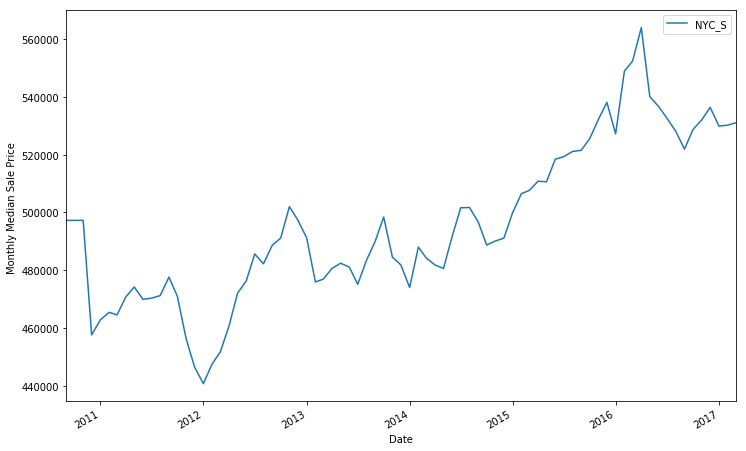

In [54]:
ax = df_ts_sale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [55]:
from fbprophet import Prophet

nycs_model = Prophet(interval_width=0.95)


In [56]:
df_ts_sale = df_ts_sale.rename(columns={'index': 'ds',
                        'NYC_S': 'y'})

df_ts_sale.head(5)

,y,ds
0,497241.772152,2010-09-01
1,497241.772152,2010-10-01
2,497241.772152,2010-11-01
3,457600.000000,2010-12-01
4,462800.000000,2011-01-01


In [57]:
nycs_model.fit(df_ts_sale)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future_dates = nycs_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [59]:
forecast = nycs_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,571568.680009,494801.485414,641276.293107
138,2021-12-01,566301.715317,487706.955182,638588.998732
139,2022-01-01,561490.596896,478649.398955,642540.772568
140,2022-02-01,562717.743180,481439.002476,641497.981712
141,2022-03-01,566100.586709,485923.175274,643895.721866


In [60]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(nycs_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,508872.324693,507646.242650,510247.015457,491100.0,2012-09-18
1,2012-11-01,553124.543114,549247.965638,556824.107248,502000.0,2012-09-18
2,2012-12-01,462737.817325,455950.641726,469827.278277,497300.0,2012-09-18
3,2013-01-01,496976.182780,485973.405016,506651.419084,491200.0,2012-09-18
4,2013-02-01,499762.201068,484389.536596,514157.080734,475900.0,2012-09-18


In [61]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,45 days,5.994369e+08,24483.399904,19359.539213,0.038564,0.259259
1,46 days,6.152367e+08,24803.966313,19710.489211,0.039348,0.259259
2,48 days,4.037922e+08,20094.582253,17421.015424,0.034761,0.259259
3,49 days,3.969989e+08,19924.830951,17154.286350,0.034190,0.296296
4,50 days,3.941883e+08,19854.176607,16993.869038,0.033872,0.333333


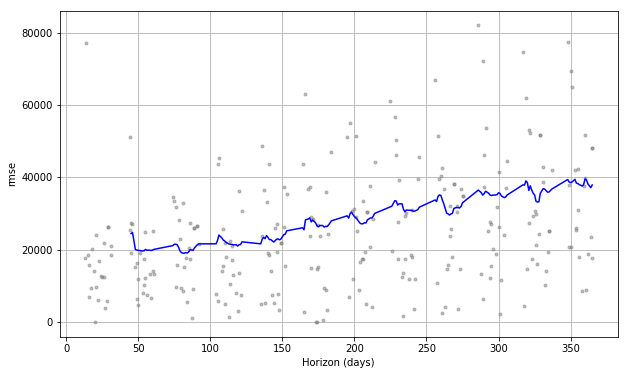

In [62]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

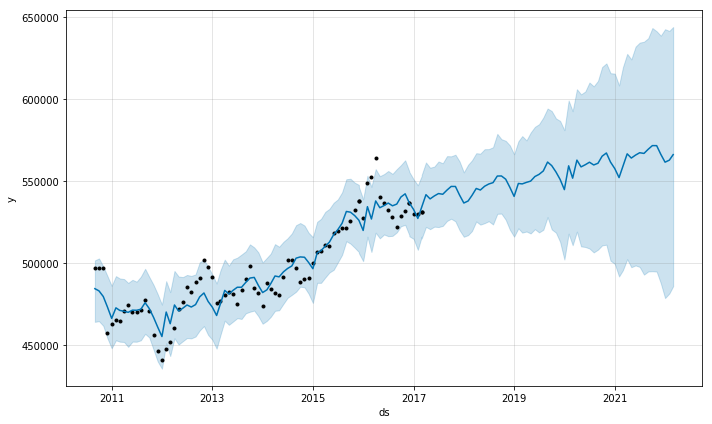

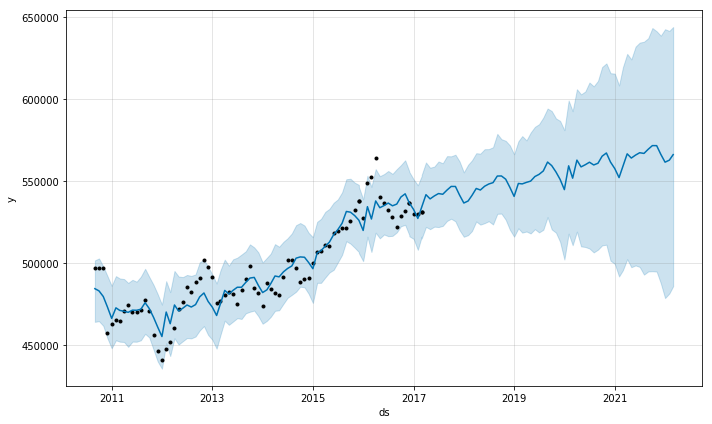

In [63]:
nycs_model.plot(forecast,
              uncertainty=True)

In [64]:
df_bossale = df_final[['Boston_S', 'index']]

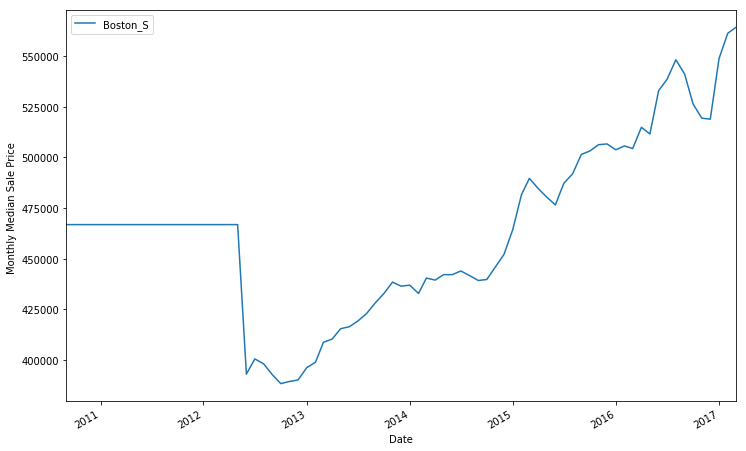

In [65]:
ax = df_bossale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [66]:
boss_model = Prophet(interval_width=0.95)


In [67]:
df_bossale = df_bossale.rename(columns={'index': 'ds',
                        'Boston_S': 'y'})

df_bossale.head(5)

,y,ds
0,466878.688525,2010-09-01
1,466878.688525,2010-10-01
2,466878.688525,2010-11-01
3,466878.688525,2010-12-01
4,466878.688525,2011-01-01


In [68]:
boss_model.fit(df_bossale)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
future_dates = boss_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [70]:
forecast = boss_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,734492.438943,554602.886277,909166.396263
138,2021-12-01,733662.221787,550017.044449,914153.364796
139,2022-01-01,746649.988542,556347.698861,933652.771231
140,2022-02-01,752012.772656,563702.182075,942762.361910
141,2022-03-01,758259.071859,559273.231757,953931.018719


In [71]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(boss_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,380468.930531,379185.643881,381948.535823,388400.0,2012-09-18
1,2012-11-01,363859.262593,359922.889001,367861.095069,389500.0,2012-09-18
2,2012-12-01,345741.543474,338768.644753,352400.379964,390200.0,2012-09-18
3,2013-01-01,327344.274389,317168.979898,337540.097578,396300.0,2012-09-18
4,2013-02-01,308451.756963,293793.876052,322419.432308,399000.0,2012-09-18


In [72]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,6.832574e+08,26139.192288,19072.780046,0.044771,0.444444
1,46 days,7.323600e+08,27062.151427,20159.218753,0.047306,0.444444
2,48 days,8.239149e+08,28703.918416,21420.168269,0.050087,0.444444
3,49 days,6.623087e+08,25735.358739,19036.276960,0.044112,0.481481
4,50 days,4.387005e+08,20945.178816,15866.037518,0.036293,0.518519
5,51 days,4.384386e+08,20938.925738,15815.498113,0.036172,0.518519
6,53 days,4.452252e+08,21100.359361,16243.196840,0.037145,0.518519
7,54 days,4.676097e+08,21624.286103,16705.419668,0.037928,0.537037
8,55 days,4.758221e+08,21813.347640,17115.112661,0.038703,0.518519
9,56 days,4.748164e+08,21790.283161,17046.106819,0.038494,0.518519


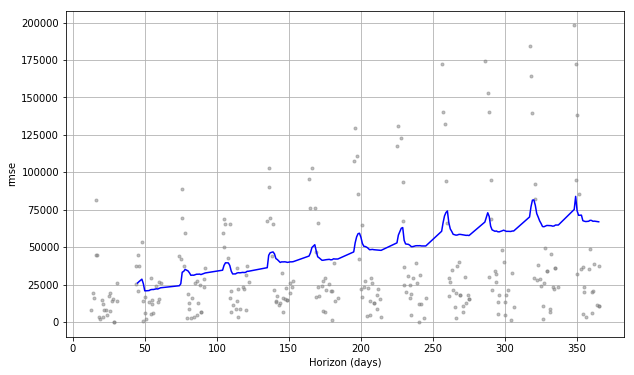

In [73]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

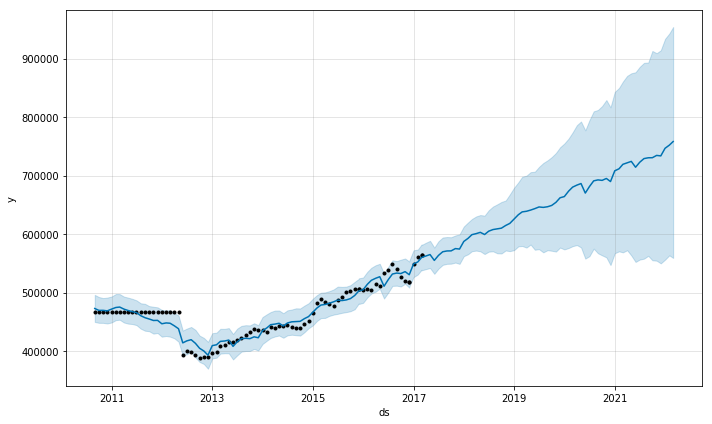

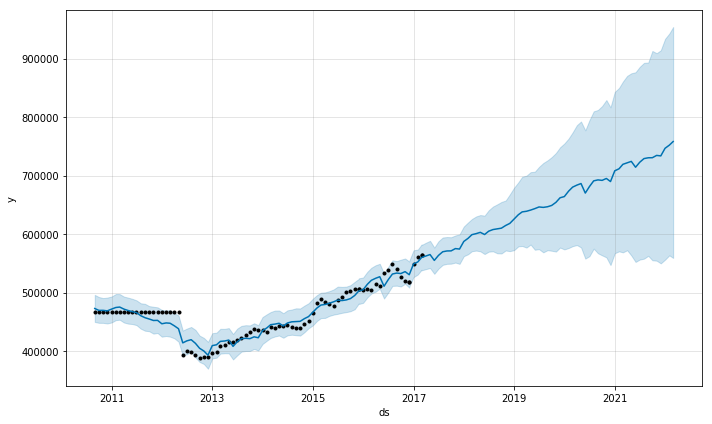

In [74]:
boss_model.plot(forecast,
              uncertainty=True)


In [75]:
df_nycrent = df_final[['NYC_R', 'index']]

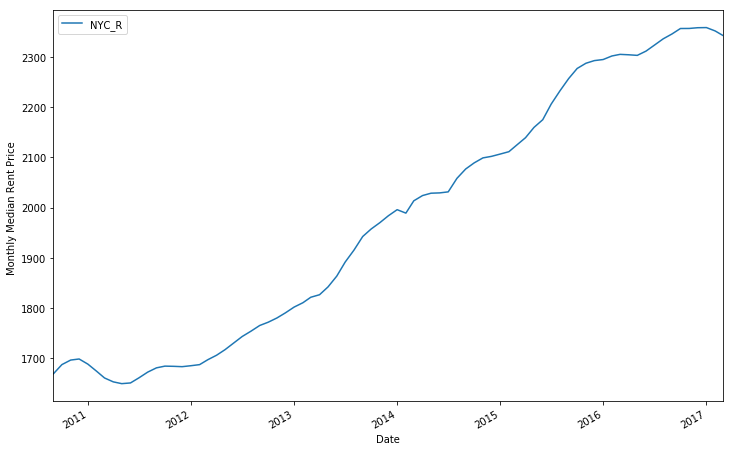

In [76]:
ax = df_nycrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [77]:
nycr_model = Prophet(interval_width=0.95)


In [78]:
df_nycrent = df_nycrent.rename(columns={'index': 'ds',
                        'NYC_R': 'y'})

df_nycrent.head(5)

,y,ds
0,1668.64,2010-09-01
1,1686.88,2010-10-01
2,1695.90,2010-11-01
3,1698.04,2010-12-01
4,1687.80,2011-01-01


In [79]:
nycr_model.fit(df_nycrent)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [80]:
future_dates = nycr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [81]:
forecast = nycr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,2620.708086,1126.273896,4029.942718
138,2021-12-01,2620.163012,1083.851541,4068.891564
139,2022-01-01,2619.967045,1059.984412,4091.219959
140,2022-02-01,2614.096471,1009.267562,4128.713109
141,2022-03-01,2617.200850,986.513203,4163.124767


In [82]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(nycr_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,1841.407513,1836.978084,1847.423813,1771.34,2012-09-18
1,2012-11-01,1865.928160,1851.993931,1881.351354,1779.81,2012-09-18
2,2012-12-01,1862.213421,1837.414183,1889.579658,1789.98,2012-09-18
3,2013-01-01,1838.214145,1799.500256,1880.064131,1801.54,2012-09-18
4,2013-02-01,1838.831024,1785.993292,1893.825481,1810.17,2012-09-18


In [83]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,654.965178,25.592287,15.727011,0.008323,0.481481
1,46 days,485.307646,22.029699,13.803405,0.007213,0.518519
2,48 days,468.289608,21.640000,13.303557,0.006917,0.555556
3,49 days,460.532757,21.460027,12.857243,0.006655,0.611111
4,50 days,483.794979,21.995340,13.490807,0.006945,0.592593
5,51 days,567.616258,23.824698,15.142989,0.007757,0.555556
6,53 days,567.884993,23.830338,15.186705,0.007776,0.555556
7,54 days,557.649644,23.614607,14.767813,0.007556,0.555556
8,55 days,570.358170,23.882173,15.206520,0.007736,0.555556
9,56 days,641.276687,25.323441,16.573413,0.008348,0.555556


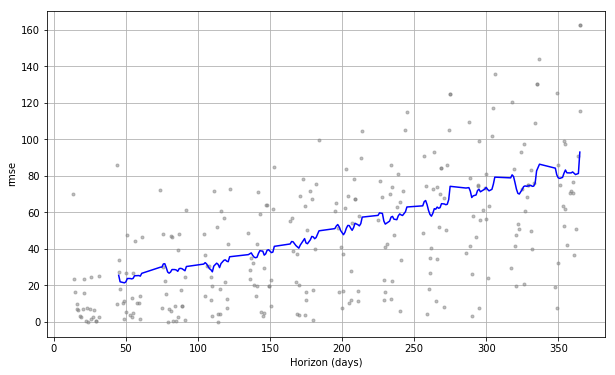

In [84]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

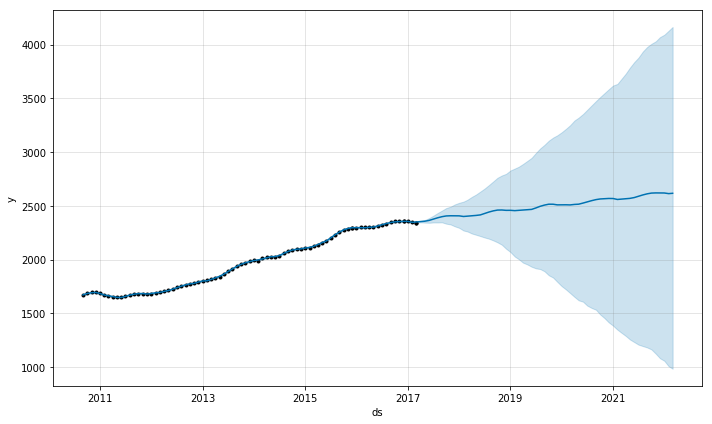

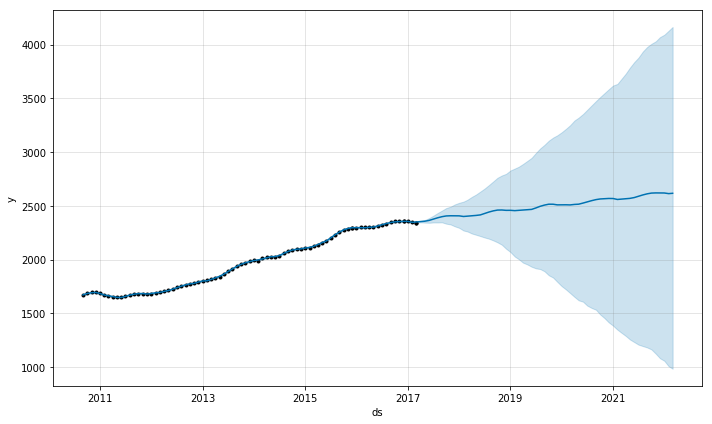

In [85]:
nycr_model.plot(forecast,
              uncertainty=True)

In [86]:
df_bosrent = df_final[['Boston_R', 'index']]

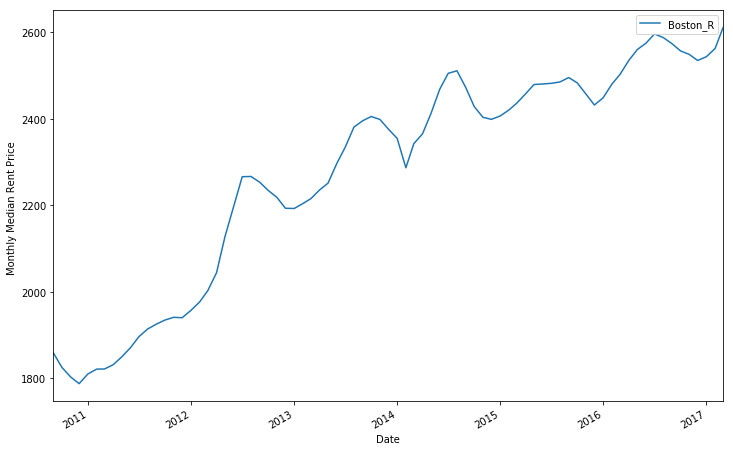

In [87]:
ax = df_bosrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [88]:
bosr_model = Prophet(interval_width=0.95)


In [89]:
df_bosrent = df_bosrent.rename(columns={'index': 'ds',
                        'Boston_R': 'y'})

df_bosrent.head(5)

,y,ds
0,1857.87,2010-09-01
1,1824.65,2010-10-01
2,1802.43,2010-11-01
3,1787.04,2010-12-01
4,1809.40,2011-01-01


In [90]:
bosr_model.fit(df_bosrent)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [91]:
future_dates = bosr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [92]:
forecast = bosr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,3029.252346,2287.850679,3789.879013
138,2021-12-01,3009.112905,2275.611117,3799.488075
139,2022-01-01,3016.846802,2261.916678,3828.883792
140,2022-02-01,3017.838008,2259.153038,3848.456142
141,2022-03-01,3046.472759,2242.512793,3885.976962


In [93]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(bosr_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,2191.390813,2181.875024,2200.323020,2234.08,2012-09-18
1,2012-11-01,2171.252776,2146.668920,2193.449698,2217.84,2012-09-18
2,2012-12-01,2194.837893,2150.510191,2233.536180,2192.73,2012-09-18
3,2013-01-01,2298.817926,2233.203354,2359.061896,2192.16,2012-09-18
4,2013-02-01,2377.496496,2287.590909,2463.483629,2203.64,2012-09-18


In [94]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,2593.959175,50.930926,40.153748,0.017161,0.444444
1,46 days,2636.620371,51.348032,40.592534,0.017319,0.444444
2,48 days,2845.160127,53.340042,42.968696,0.018294,0.444444
3,49 days,2941.207958,54.232905,44.144266,0.018734,0.407407
4,50 days,2955.105691,54.360884,43.150578,0.018280,0.444444
5,51 days,2934.067758,54.167036,42.779471,0.018111,0.481481
6,53 days,3035.575403,55.096056,43.945907,0.018566,0.481481
7,54 days,3041.261083,55.147630,44.657881,0.018814,0.462963
8,55 days,2801.755839,52.931615,42.439811,0.017853,0.481481
9,56 days,2761.663637,52.551533,42.146055,0.017710,0.481481


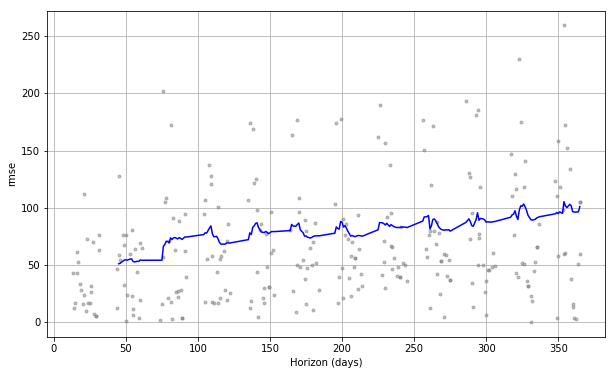

In [95]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

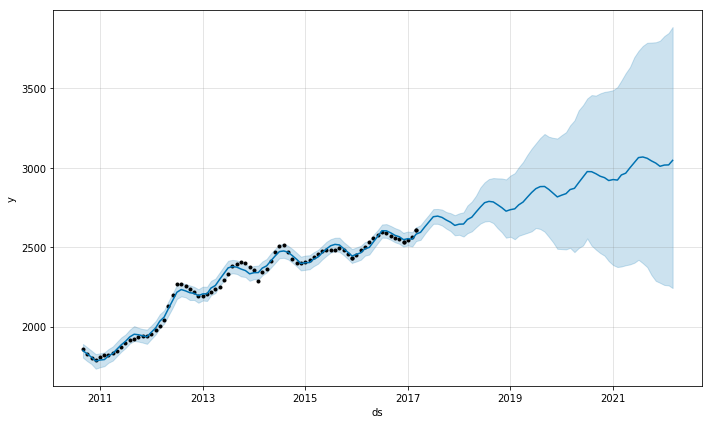

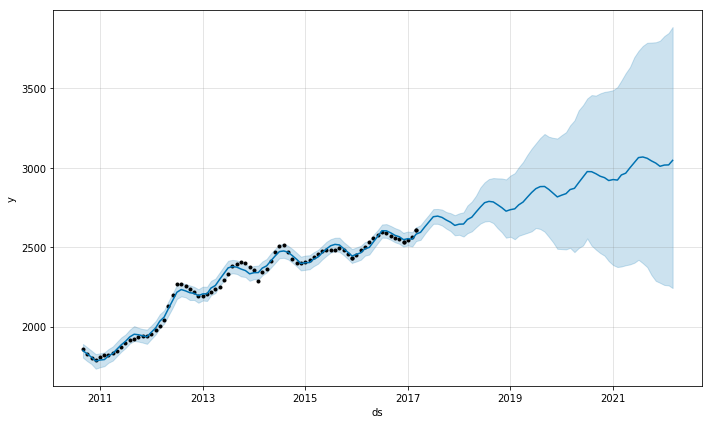

In [96]:
bosr_model.plot(forecast,
              uncertainty=True)